In [44]:
# !conda install matplotlib scikit-learn pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

In [45]:
import torch, torchvision
import torchvision.transforms as transforms

# Check if graphics card is available, otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 10
BATCH_SIZE = 200
LEARNING_RATE = 0.001

# Normalize to Tensor of normalize range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Load in FashionMNIST train and test set
train_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=False, download=True, transform=transform)

# Load dataset into dataloader for batch iterations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# All 10 available classes for the FashionMNIST dataset
classes= ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

In [46]:
# Examine a sample
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([200, 1, 28, 28])
torch.Size([200])


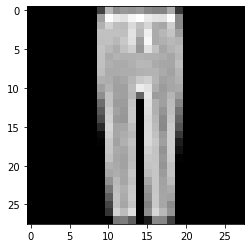

In [47]:
import matplotlib.pyplot as plt

# Show sample
plt.imshow(images[0].numpy().squeeze(), cmap="Greys_r")

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import random

# Resize and pad image randomly to given img_size
# Used as defense
def pad_img_tensor(x, img_size):
    # x: 4-dimensional tensor which includes image(s) to be resized and padded in the 1st and 2nd dimension
    # img_size: Width and height of input image x given as single int
    width = random.randint(img_size - 5, img_size)
    height = random.randint(img_size - 5, img_size)
    resized_image = transforms.functional.resize(x, size=(width,height))
    shape = list(resized_image.shape)
    width = shape[2]
    height = shape[3]
    padding_width = random.randint(0, img_size-width)
    padding_height = random.randint(0, img_size-height)
    if (random.randint(0, 1)):
        padding_width_right = padding_width
        padding_width_left = img_size - width - padding_width
        padding_height_top = padding_height
        padding_height_bottom = img_size - height - padding_height
    else:
        padding_width_right = img_size - width - padding_width
        padding_width_left = padding_width
        padding_height_top = img_size - height - padding_height
        padding_height_bottom = padding_height
    x = transforms.functional.pad(resized_image, padding=(padding_height_top, padding_width_left, padding_height_bottom, padding_width_right))
    return x

class CNN(nn.Module):
    def __init__(self, padding, img_size):
        # padding: Boolean to check if input should be resized and padded
        # img_size: The size of the image or to which size the image should be resized and padded
        super().__init__()
        self.padding = padding
        self.img_size = img_size
        # Input: 1 x img_size x img_size
        # 1 input channel, 5 output channels, kernel size of 7x7
        # Output: 5 x img_size-6 x img_size-6 due to kernelsize = 7
        self.conv1 = nn.Conv2d(1, 5, 7)
        self.conv1_drop = nn.Dropout2d(0.2)
        # Input: 5 x img_size-6 x img_size-6
        # 5 input channel, 12 output channels, kernel size of 5x5
        # Output: 12 x img_size-10 x img_size-10 due to kernelsize = 5
        self.conv2 = nn.Conv2d(5, 12, 5)
        self.conv2_drop = nn.Dropout2d(0.2)
        # Input: 12 x img_size-10 x img_size-10
        # Kernel size of 2x2
        # Output: 12 x (img_size-10)/2 x (img_size-10)/2
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(int(12 * ((self.img_size-10)/2) * ((self.img_size-10)/2)), 256)
        self.fc_drop = nn.Dropout2d(0.3)
        self.fc2 = nn.Linear(256, 10)
        pass

    def forward(self, x):
        if (self.padding):
            x = pad_img_tensor(x, self.img_size)
        x = self.conv1(x)
        x = self.conv1_drop(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc_drop(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class DEF_RESNET(nn.Module):
    def __init__(self, precreated_model, padding, img_size):
        # precreated_model: Other NN that is used within this NN
        # padding: Boolean to check if input should be resized and padded
        # img_size: The size of the image or to which size the image should be resized and padded
        super().__init__()
        self.precreated = precreated_model
        self.padding = padding
        self.img_size = img_size
        pass
    
    def forward(self, x):
        if (self.padding):
            x = pad_img_tensor(x, self.img_size)
        x = self.precreated(x)
        return x

In [49]:
from torchvision.models import resnet50

# Use own CNN model or use precreated Resnet50 model
USE_OWN_NN = False

if (USE_OWN_NN):
    model = CNN(False, 28)
else:
    model = DEF_RESNET(resnet50(), False, 28)
    # Replace first convolutional layer as to make it possible to use single color images
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

DEF_RESNET(
  (precreated): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [50]:
import time, math
from sklearn.metrics import accuracy_score

def train():
    start = time.time()
    train_losses = []
    test_losses = []

    for epoch in range(EPOCHS):

        # Train mode
        model.train()

        for i, batch in enumerate(train_loader):
            # Send data to device
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward + backward + optimize
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                train_loss = criterion(outputs, labels)
                train_loss.backward()
                optimizer.step()

            # Setup batch statistics
            preds = torch.argmax(outputs, dim=1)
            correct = torch.sum(torch.eq(preds, labels)).item()
            elapsed = time.time() - start

            # Print training statistics
            if not i % (math.ceil(len(train_loader) / 4)):
                    print(f'epoch: {epoch}, batch: {i:<{len(str(len(train_loader)))}}/{len(train_loader)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
            
        train_losses.append(train_loss.item())

        # Evaluation mode
        model.eval()
        
        batch_acc = []

        for i, batch in enumerate(test_loader):
            # Send data to device
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                preds = torch.argmax(outputs, dim=1)
                preds = preds.to(device).tolist()
                batch_acc.append(accuracy_score(preds, labels.tolist()))
                test_loss = criterion(outputs, labels.long())

        # Print test statistics
        print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

        test_losses.append(test_loss.item())
    return (train_losses, test_losses)
train_losses, test_losses = train()

epoch: 0, batch: 0  /300, time: 0.380s, loss: 7.152, acc: 0.005
epoch: 0, batch: 75 /300, time: 10.151s, loss: 0.510, acc: 0.825
epoch: 0, batch: 150/300, time: 20.039s, loss: 0.494, acc: 0.800
epoch: 0, batch: 225/300, time: 30.312s, loss: 0.457, acc: 0.860
Accuracy on the test set: 0.849
epoch: 1, batch: 0  /300, time: 43.305s, loss: 0.349, acc: 0.900
epoch: 1, batch: 75 /300, time: 53.397s, loss: 0.284, acc: 0.915
epoch: 1, batch: 150/300, time: 63.593s, loss: 0.307, acc: 0.895
epoch: 1, batch: 225/300, time: 73.638s, loss: 0.336, acc: 0.855
Accuracy on the test set: 0.874
epoch: 2, batch: 0  /300, time: 86.908s, loss: 0.257, acc: 0.895
epoch: 2, batch: 75 /300, time: 96.974s, loss: 0.324, acc: 0.900
epoch: 2, batch: 150/300, time: 107.040s, loss: 0.344, acc: 0.870
epoch: 2, batch: 225/300, time: 117.179s, loss: 0.260, acc: 0.910
Accuracy on the test set: 0.874
epoch: 3, batch: 0  /300, time: 130.516s, loss: 0.176, acc: 0.930
epoch: 3, batch: 75 /300, time: 140.604s, loss: 0.199, ac

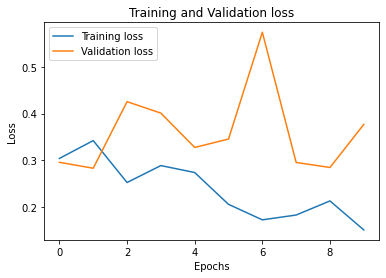

In [51]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
import os

path = "model/"
if not os.path.exists(path):
  os.makedirs(path)

if (USE_OWN_NN):
  torch.save(model.state_dict(), path + "own_model.pth")
else:
  torch.save(model.state_dict(), path + "resnet_model.pth")

In [53]:
path = "model/"
if (USE_OWN_NN):
    CNN(False, 28)
    model.load_state_dict(torch.load(path + "own_model.pth"))
else:
    model = DEF_RESNET(resnet50(), False, 28)
    # Replace first convolutional layer as to make it possible to use single color images
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.load_state_dict(torch.load(path + "resnet_model.pth"))
model = model.to(device)
model.eval()

DEF_RESNET(
  (precreated): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

# Attacks  

FGSM:  
$x_{adv}=x+\epsilon*sign(\nabla_{x}J(\theta,x,y))$  

I-FGSM:  
$Clip_{X,\epsilon}\{x^{n+1}_{adv}+step*sign(\nabla_{x^{n}_{adv}}J(\theta,x^{n}_{adv},y))\}$  
$x^{0}_{adv}=x$  

PGD:  
$x^{n+1}_{adv}=arg\;min_{x \in J}||x^{n}_{adv}-step*\nabla J(\theta,x^{n}_{adv},y)-x||$  
$x^{0}_{adv}=x$

In [54]:
import sys

# FGSM attack code
def fgsm(model, image, label, epsilon):
    output = model(image)
    # Calculate the loss
    cost = criterion(output, label).to(device)
    # Zero all existing gradients
    model.zero_grad()
    # Calculate gradients of model in backward pass
    cost.backward()
    # Collect datagrad
    data_grad = image.grad.data
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

def pgd(model, image, label, epsilon, step=0.2, num_steps=40):
    for _ in range(num_steps):
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        # Calculate loss
        cost = criterion(output, label).to(device)
        cost.backward()
        
        # adv_image = image + image.grad * step / image.grad.view(image.shape[0], -1).norm(2, dim=-1)\
        #             .view(-1, 1, 1, 1)
        # eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        # adv_image = torch.clamp(image + eta, min=-1, max=1).detach_()
        # return adv_image

        adv_image = image - step*step.grad
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach_()
        return adv_image
        
def iterative_fgsm(model, image, label, epsilon, step=0.2, num_steps=40):
    image = image.clone().detach()
    adv_image = image.clone().detach()
    for _ in range(num_steps):
        adv_image.requires_grad = True
        output = model(adv_image)
        cost = criterion(output, label).to(device)
        cost.backward()
        data_grad = adv_image.grad.data
        adv_image = adv_image.detach() + step*data_grad.sign()
        eta = torch.clamp(adv_image - image, min=-epsilon, max=epsilon)
        adv_image = torch.clamp(image + eta, min=-1, max=1).detach()
    return adv_image

def test(model, device, test_loader, epsilon, attack):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = torch.argmax(output, dim=1)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (attack == "fgsm"):
            # Call FGSM Attack
            perturbed_data = fgsm(model, data, target, epsilon)
        elif (attack == "iterative_fgsm"):
            perturbed_data = iterative_fgsm(model, data, target, epsilon)
        elif (attack == "pgd"):
            # Call PGD Attack
            perturbed_data = pgd(model, data, target, epsilon)
        else:
            print("You have selected an attack method which is not implemented.\nPlease alter " + attack + ".")
            sys.exit()
        
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
    

In [55]:
EPSILONS = [0, .05, .1, .15, .2, .25, .3]
# Choose from fgsm, iterative_fgsm, pgd 
ATTACK = "fgsm"

def adversial_attack(epsilons, attack, model):
    accuracies = []
    examples = []

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, eps, attack)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies, examples

accuracies, examples = adversial_attack(EPSILONS, ATTACK, model)

Epsilon: 0	Test Accuracy = 8919 / 10000 = 0.8919
Epsilon: 0.05	Test Accuracy = 5112 / 10000 = 0.5112
Epsilon: 0.1	Test Accuracy = 3441 / 10000 = 0.3441
Epsilon: 0.15	Test Accuracy = 2546 / 10000 = 0.2546
Epsilon: 0.2	Test Accuracy = 2015 / 10000 = 0.2015
Epsilon: 0.25	Test Accuracy = 1686 / 10000 = 0.1686
Epsilon: 0.3	Test Accuracy = 1476 / 10000 = 0.1476


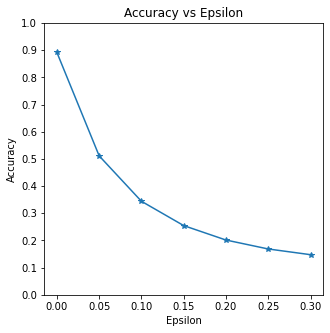

In [56]:
import numpy as np

plt.figure(figsize=(5,5))
plt.plot(EPSILONS, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

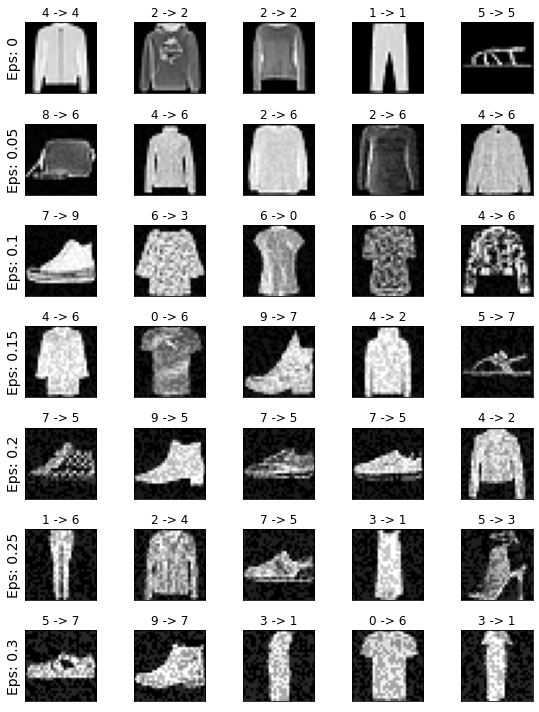

In [57]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# Defense

In [59]:
if (USE_OWN_NN):
    model = CNN(True, 36)
else:
    model = DEF_RESNET(resnet50(), True, 36)
    model.precreated.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, test_losses = train()

epoch: 0, batch: 0  /300, time: 0.295s, loss: 7.075, acc: 0.000
epoch: 0, batch: 75 /300, time: 16.925s, loss: 0.611, acc: 0.750
epoch: 0, batch: 150/300, time: 31.801s, loss: 0.556, acc: 0.775
epoch: 0, batch: 225/300, time: 46.529s, loss: 0.425, acc: 0.805
Accuracy on the test set: 0.847
epoch: 1, batch: 0  /300, time: 64.217s, loss: 0.342, acc: 0.855
epoch: 1, batch: 75 /300, time: 78.071s, loss: 0.356, acc: 0.880
epoch: 1, batch: 150/300, time: 92.181s, loss: 0.292, acc: 0.890
epoch: 1, batch: 225/300, time: 106.097s, loss: 0.335, acc: 0.860
Accuracy on the test set: 0.852
epoch: 2, batch: 0  /300, time: 123.959s, loss: 0.436, acc: 0.835
epoch: 2, batch: 75 /300, time: 137.784s, loss: 0.347, acc: 0.860
epoch: 2, batch: 150/300, time: 151.914s, loss: 0.399, acc: 0.840
epoch: 2, batch: 225/300, time: 165.757s, loss: 0.334, acc: 0.860
Accuracy on the test set: 0.871
epoch: 3, batch: 0  /300, time: 183.996s, loss: 0.369, acc: 0.865
epoch: 3, batch: 75 /300, time: 197.861s, loss: 0.313,

In [60]:
accuracies, examples = adversial_attack(EPSILONS, ATTACK, model)

TypeError: adversial_attack() missing 1 required positional argument: 'model'